In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from collections import Counter
import re
import pandas as pd

In [2]:
syllables = [
  ["ma", "si", "mu", "zu", "da", "jo", "ke", "py", "za"],
  ["vo", "lu", "re", "vi", "zo", "be", "ru", "pe", "te"],
  ["suk", "mák", "nos", "sen", "výr", "mech", "len", "gól", "cíp"],
  ["nov", "lar", "for", "zul", "bed", "lum", "nev", "zek", "vod"],
  ["vl", "bz", "hr", "dr", "sl", "kr", "ol", "ml", "fr"],
  ["tra", "mle", "tve", "kro", "dlu", "sku", "bru", "pla", "klu"],
  ["vle", "tra", "mru", "čle", "chlu", "pro", "zlu", "sla", "fro"],
  ["pluh", "hrom", "mlýn", "dnes", "plot", "zvuk", "vnuk", "lhář", "kmen"],
  ["vpád", "stop", "hned", "vkus", "chlup", "zrak", "plat", "vrak", "zvon"],
  ["tvrz", "skrz", "smrt", "brnk", "smrk", "blesk", "štěrk", "kvést", "bronz"]
]

In [3]:
meaningfulText = [
    "Malý Pepík raději četl doma knížky plné dobrodružství, než aby skotačil s dětmi venku.",
    "Možná k tomu přispěla i nemocná noha, která mu mnohé neplechy znemožňovala. Raději se",
    "proto ponořil do příběhů plných plížících se indiánů, odvážných zálesáků nebo zlotřilých",
    "pirátů. Občas smutně vyhlédl z okna na hrající si kamarády a sledoval zpovzdálí jejich",
    "rozpustilou hru. Jednoho dne, když se jako obvykle díval částečně ukrytý za záclonou, si",
    "uvědomil, že nějaký stín se jako blesk pohybuje po stromě nahoru a dolů. Malá hnědá a velice",
    "hbitá veverka šmejdila po stromě a hledala oříšky, které by si uschovala do tajné skrýše."
]

In [4]:
pseudoText = [
    "Vůrnice lobu saná ladiv. Šini se zonaj olitače a jiprá tibý sa takode koumi toudíc. Vazpíla",
    "mupotá, sidóla lib mozdá, rompulo sa řazvíty. Hoče se hašlá řilozá stým a ravízda. Douje",
    "bocha šakve lámě. Tašelá sně pronitě šere. Každépo rytách pronity harto e šere chlera dlypo.",
    "Desedé a haralice o kačeza te krozdoníka. Krozdoník subaj šelprí kýmlech remhol s",
    "hanymítory šeremi pakaty um zysly iz trpní sných krá tůkva. Humo tebi mecipo? Požeš meny,",
    "kada tasnepře bličovasa muto dinéje, roč mitulore. Subaj límal vůrnice ka libe. Šelprí tadýt a",
    "ruěvin le. Myja lépa dodim aki toukané ili lédé. Matako tudom lehou řepine."
]

In [5]:
# Load Czech BERT model
model_name = "UWB-AIR/Czert-B-base-cased"  # Czech BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/214k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

In [6]:
# Define Czech vowels and consonants
czech_vowels = "aáeéěiíoóuúůyý"
czech_consonants = "bcčdďfghjklmnňpqrřsštťvwxzž"

# **I. Phonetic-Orthographic Complexity Features**

In [7]:
def is_vowel(char):
    return char.lower() in czech_vowels

def is_consonant(char):
    return char.lower() in czech_consonants

In [8]:
def get_consonant_clusters(word):
    """Extract consonant clusters from a word."""
    clusters = []
    current_cluster = ""

    for char in word.lower():
        if is_consonant(char):
            current_cluster += char
        else:
            if current_cluster:
                clusters.append(current_cluster)
                current_cluster = ""

    if current_cluster:  # Add final cluster if word ends with consonants
        clusters.append(current_cluster)

    return clusters

In [9]:
def calculate_cluster_density(word):
    """Calculate the ratio of consonant clusters to total characters."""
    clusters = get_consonant_clusters(word)
    cluster_chars = sum(len(cluster) for cluster in clusters)
    return cluster_chars / len(word) if len(word) > 0 else 0

In [10]:
def calculate_vowel_positions(word):
    """Calculate the positions of vowels in the word."""
    positions = []
    for i, char in enumerate(word.lower()):
        if is_vowel(char):
            positions.append(i)
    return positions

In [11]:
def sonority_score(phoneme):
    """
    Calculate sonority score for a phoneme based on the Sonority Sequencing Principle.
    Higher values = more sonorous.
    """
    sonority_scale = {
    # Vowels (PEAK = 10) - Length irrelevant for SSP
    'a':10, 'á':10, 'e':10, 'é':10, 'ě':10, 'i':10, 'í':10,
    'o':10, 'ó':10, 'u':10, 'ú':10, 'ů':10, 'y':10, 'ý':10,

    # Glides (9) - Higher than liquids
    'j':9,

    # Liquids (7) - Includes Czech-specific ř
    'l':7, 'r':7, 'ř':7,

    # Nasals (5)
    'm':5, 'n':5, 'ň':5,

    # Fricatives (3) - Voiced/Voiceless same tier
    'v':3, 'z':3, 'ž':3, 's':3, 'š':3, 'f':3, 'h':3, 'ch':3,

    # Affricates (2) - Treat as stops
    'c':2, 'č':2, 'dz':2, 'dž':2,

    # Stops (1) - Voicing irrelevant for SSP
    'b':1, 'd':1, 'ď':1, 'g':1, 'p':1, 't':1, 'ť':1, 'k':1
}
    return sonority_scale.get(phoneme.lower(), 0)

In [12]:
def calculate_ssp_naturalness(cluster, sonority_scale,  position='onset'):
    """
    Calculate SSP compliance with Czech-specific adjustments.
    Returns: 0 (perfect compliance) to 1 (severe violation)
    """
    if len(cluster) <= 1:
        return 0.0

    scores = [sonority_scale[c] for c in cluster]
    peak_idx = scores.index(max(scores))

    # Czech-specific SSP rules
    if position == 'onset':
        # Onset requires rising sonority to peak
        pre_peak = scores[:peak_idx]
        return sum(1 for i in range(1, len(pre_peak)) if pre_peak[i] <= pre_peak[i-1])/len(cluster)

    elif position == 'coda':
        # Coda requires falling sonority from peak
        post_peak = scores[peak_idx+1:]
        return sum(1 for i in range(1, len(post_peak)) if post_peak[i] >= post_peak[i-1])/len(cluster)

    else:  # Ambiguous position
        onset_errors = sum(1 for i in range(1, len(scores)) if scores[i] <= scores[i-1])
        coda_errors = sum(1 for i in range(1, len(scores)) if scores[i] >= scores[i-1])
        return min(onset_errors, coda_errors)/len(cluster)


In [ ]:
def orthographic_transparency(word):
    """
    Calculate orthographic transparency based on letter-to-sound mapping complexity.
    Lower scores mean more transparent (consistent) spelling.
    """
    # Define ambiguous graphemes in Czech
    ambiguous_graphemes = {
        'ě': 1.5,  # Affects pronunciation of preceding consonant
        'ů': 1.2,  # Historical alternation with 'ó'
        'x': 1.5,  # Represents two phonemes /ks/
        'q': 1.5,  # Foreign letter representing /kv/ sequence
        'w': 1.2,  # Foreign letter
        'ch': 1.3,  # Digraph representing single phoneme
        'dž': 1.3,  # Digraph
        'au': 1.2,  # Diphthong
        'eu': 1.2,  # Diphthong
        'ou': 1.2,  # Diphthong
    }

    score = 1.0  # Base transparency score

    # Check for ambiguous graphemes
    for grapheme, penalty in ambiguous_graphemes.items():
        if grapheme in word.lower():
            score *= penalty

    # Check for diacritics
    diacritics = 'áéěíóúůýčďňřšťž'
    for char in diacritics:
        if char in word.lower():
            score *= 1.1  # Small penalty for diacritics

    return score

# **II. Syllable Structure Features**

In [ ]:
def identify_syllable_type(syllable):
    """
    Identify the type of syllable structure (CV, CVC, CC, CCV, CCCV, etc.)
    """
    pattern = ""
    for char in syllable.lower():
        if is_vowel(char):
            pattern += "V"
        elif is_consonant(char):
            pattern += "C"
        else:
            pattern += "X"  # For non-letter characters

    return pattern

In [ ]:
def syllable_difficulty_score(syllable):
    """
    Calculate difficulty score based on syllable type.
    Higher score = more difficult.
    """
    pattern = identify_syllable_type(syllable)

    difficulty_map = {
        "CV": 1,       # Low difficulty (open syllable)
        "CVC": 2,      # Moderate difficulty (closed syllable)
        "VC": 1.5,     # Moderate-low
        "V": 1,        # Low (just a vowel)
        "CC": 3,       # High (consonant only)
        "CCV": 3,      # High (consonant cluster + vowel)
        "CCCV": 4,     # Very high (complex cluster + vowel)
        "CCVC": 3.5,   # High (cluster + vowel + consonant)
        "CCCVC": 4.5,  # Very high (complex)
        "CVCC": 3,     # High (vowel + consonant cluster)
        "CCVCC": 4     # Very high (complex)
    }

    # Default difficulty for unlisted patterns: calculate based on consonant clusters
    default_difficulty = 1 + (pattern.count("C") / 2.0)

    return difficulty_map.get(pattern, default_difficulty)

In [ ]:
def positional_difficulty(syllable, matrix_position):
    """
    Calculate positional difficulty based on matrix position.
    As provided in your pseudocode.
    """
    row_num, col_num = matrix_position
    base_difficulty = syllable_difficulty_score(syllable)
    row_weight = 0.8**(9 - row_num)  # Lower rows = harder
    col_weight = 1 + (col_num/10)*0.2  # Rightward progression
    return base_difficulty * row_weight * col_weight

In [ ]:
def syllable_boundary_ambiguity(word):
    """
    Estimate the ambiguity of syllable boundaries.
    Higher score means more ambiguous boundaries.
    """
    # Identify possible syllable boundary positions
    possible_boundaries = []

    for i in range(1, len(word)-1):
        # Common boundary cases: between vowel and consonant
        if is_vowel(word[i-1]) and is_consonant(word[i]):
            possible_boundaries.append(i)
        # Between two consonants (depends on sonority)
        elif is_consonant(word[i-1]) and is_consonant(word[i]):
            son1 = sonority_score(word[i-1])
            son2 = sonority_score(word[i])
            # Decreasing sonority often indicates a syllable boundary
            if son1 > son2:
                possible_boundaries.append(i)

    # Calculate ambiguity based on multiple possible boundaries
    return len(possible_boundaries)

# **III. Psycholinguistic Features**

In [ ]:
def is_meaningful(word, model, tokenizer):
    """
    Determine if a word is meaningful based on BERT embedding properties.
    Returns a confidence score (higher = more likely meaningful).
    """
    # Encode the word
    inputs = tokenizer(word, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state

    # Calculate vector norm (magnitude) - real words tend to have more focused embedding
    embedding_norm = torch.norm(embeddings).item()

    # Calculate entropy of the embedding - real words have lower entropy
    embedding_flat = embeddings.flatten().numpy()
    embedding_probabilities = np.abs(embedding_flat) / np.sum(np.abs(embedding_flat))
    entropy = -np.sum(embedding_probabilities * np.log2(embedding_probabilities + 1e-10))

    # Combine metrics (normalized to 0-1 range)
    normalized_norm = min(1.0, embedding_norm / 20.0)  # Normalize with reasonable upper limit
    normalized_entropy = max(0.0, 1.0 - (entropy / 10.0))  # Invert entropy

    meaningfulness_score = 0.6 * normalized_norm + 0.4 * normalized_entropy

    return meaningfulness_score

In [ ]:
def calculate_neighborhood_density(word, word_list):
    """
    Calculate phonological neighborhood density.
    Counts words that differ by a single phoneme.
    """
    neighborhood = 0

    for other_word in word_list:
        if word != other_word and len(word) == len(other_word):
            differences = sum(1 for a, b in zip(word, other_word) if a != b)
            if differences == 1:
                neighborhood += 1

    return neighborhood

In [ ]:
def morphological_complexity(word):
    """
    Estimate morphological complexity based on affixes and palatalization.
    Higher score = more complex.
    """
    score = 1.0

    # Check for common Czech prefixes
    prefixes = ["na", "od", "po", "pro", "pře", "při", "roz", "s", "u", "v", "vy", "z", "za"]
    for prefix in prefixes:
        if word.lower().startswith(prefix):
            score += 0.5
            break

    # Check for common Czech suffixes
    suffixes = ["ost", "ství", "tel", "ce", "ník", "ík", "ka", "ek", "ice", "ina"]
    for suffix in suffixes:
        if word.lower().endswith(suffix):
            score += 0.5
            break

    # Check for palatalization patterns
    palatalization_pairs = [
        ("t", "ť"), ("d", "ď"), ("n", "ň"),
        ("k", "č"), ("h", "ž"), ("ch", "š")
    ]

    for base, palatalized in palatalization_pairs:
        if base in word and palatalized in word:
            score += 0.3

    return score

# **IV. Visual-Linguistic Interaction Features**

In [ ]:
def letter_confusability_score(word):
    """
    Calculate confusability score based on visually similar letters.
    Higher score = more confusable letters.
    """
    confusable_groups = [
        ["b", "d", "p", "q"],  # Mirror/rotation confusable
        ["m", "n", "u"],       # Similar shapes
        ["i", "j", "l"],       # Minimal letters
        ["v", "w"],            # Similar shapes
        ["c", "e", "o"],       # Rounded shapes
        ["f", "t"],            # Cross letters
        ["h", "n"],            # Similar shapes
        ["š", "s"],            # Diacritic variation
        ["č", "c"],            # Diacritic variation
        ["ř", "r"],            # Diacritic variation
        ["ž", "z"],            # Diacritic variation
        ["ě", "e"],            # Diacritic variation
    ]

    confusability = 0

    for char in word.lower():
        for group in confusable_groups:
            if char in group and sum(1 for c in word.lower() if c in group) > 1:
                confusability += 1

    return confusability

In [ ]:
def calculate_ascender_descender_density(word):
    """
    Calculate the density of letters with ascenders and descenders.
    """
    ascenders = "bdfhklťďľ"
    descenders = "gjpqyý"

    ascender_count = sum(1 for c in word.lower() if c in ascenders)
    descender_count = sum(1 for c in word.lower() if c in descenders)

    return (ascender_count + descender_count) / len(word) if len(word) > 0 else 0

In [ ]:
def spatial_crowding_metric(word):
    """
    Calculate spatial crowding based on letter width estimates.
    Higher values = more crowded.
    """
    # Approximate width based on Times New Roman font (relative units)
    letter_widths = {
        'i': 0.5, 'j': 0.5, 'l': 0.5, 'I': 0.5,  # Narrow
        'f': 0.6, 'r': 0.6, 't': 0.6,            # Narrow-medium
        'a': 0.7, 'b': 0.7, 'c': 0.7, 'd': 0.7, 'e': 0.7, 'g': 0.7, 'h': 0.7,
        'k': 0.7, 'n': 0.7, 'o': 0.7, 'p': 0.7, 'q': 0.7, 's': 0.7, 'u': 0.7,
        'v': 0.7, 'x': 0.7, 'y': 0.7, 'z': 0.7,  # Medium
        'm': 1.0, 'w': 1.0, 'ž': 0.8, 'š': 0.8, 'č': 0.8  # Wide
    }

    # Average character width
    total_width = sum(letter_widths.get(c.lower(), 0.7) for c in word)
    avg_width = total_width / len(word) if len(word) > 0 else 0

    # Calculate variation in width (more variation = less crowded)
    width_variation = np.std([letter_widths.get(c.lower(), 0.7) for c in word]) if len(word) > 0 else 0

    # Crowding increases with density and decreases with variation
    crowding = (1 / avg_width) * (1 / (width_variation + 0.1))

    return crowding

# **Main analysis functions**

In [ ]:
def analyze_syllable_matrix():
    """Analyze the matrix of syllables"""
    results = []

    flat_syllables = [item for sublist in syllables for item in sublist]

    for row_idx, row in enumerate(syllables):
        for col_idx, syllable in enumerate(row):
            result = {
                'syllable': syllable,
                'row': row_idx + 1,
                'column': col_idx + 1,
                'syllable_type': identify_syllable_type(syllable),
                'difficulty_score': syllable_difficulty_score(syllable),
                'positional_difficulty': positional_difficulty(syllable, (row_idx, col_idx)),
                'cluster_density': calculate_cluster_density(syllable),
                'orthographic_transparency': orthographic_transparency(syllable),
                'consonant_clusters': get_consonant_clusters(syllable),
                'letter_confusability': letter_confusability_score(syllable),
                'ascender_descender_density': calculate_ascender_descender_density(syllable),
                'spatial_crowding': spatial_crowding_metric(syllable),
                'neighborhood_density': calculate_neighborhood_density(syllable, flat_syllables)
            }
            results.append(result)

    return pd.DataFrame(results)

In [ ]:
def analyze_text(text, is_meaningful_text=True, model=model, tokenizer=tokenizer):
    """Analyze a text passage word by word"""
    # Combine text lines and split into words
    full_text = ' '.join(text)
    words = re.findall(r'\w+', full_text)

    results = []
    for word in words:
        if len(word) > 0:
            result = {
                'word': word,
                'length': len(word),
                'syllable_types': identify_syllable_type(word),
                'difficulty_score': syllable_difficulty_score(word),
                'cluster_density': calculate_cluster_density(word),
                'orthographic_transparency': orthographic_transparency(word),
                'consonant_clusters': get_consonant_clusters(word),
                'syllable_boundary_ambiguity': syllable_boundary_ambiguity(word),
                'meaningfulness_score': 0.9 if is_meaningful_text else is_meaningful(word, model, tokenizer),
                'morphological_complexity': morphological_complexity(word),
                'letter_confusability': letter_confusability_score(word),
                'ascender_descender_density': calculate_ascender_descender_density(word),
                'spatial_crowding': spatial_crowding_metric(word)
            }
            results.append(result)

    return pd.DataFrame(results)

In [ ]:
def compare_texts():
    """Compare meaningful vs pseudo-text characteristics"""
    meaningful_analysis = analyze_text(meaningfulText, True)
    pseudo_analysis = analyze_text(pseudoText, False)

    comparison = {
        'metric': [],
        'meaningful_text_avg': [],
        'pseudo_text_avg': [],
        'difference': [],
        'percent_difference': []
    }

    numeric_columns = [col for col in meaningful_analysis.columns if col != 'word' and
                       col != 'consonant_clusters' and meaningful_analysis[col].dtype != 'object']

    for col in numeric_columns:
        meaningful_avg = meaningful_analysis[col].mean()
        pseudo_avg = pseudo_analysis[col].mean()
        diff = pseudo_avg - meaningful_avg
        pct_diff = (diff / meaningful_avg) * 100 if meaningful_avg != 0 else float('inf')

        comparison['metric'].append(col)
        comparison['meaningful_text_avg'].append(meaningful_avg)
        comparison['pseudo_text_avg'].append(pseudo_avg)
        comparison['difference'].append(diff)
        comparison['percent_difference'].append(pct_diff)

    return pd.DataFrame(comparison)

In [ ]:
# Run the analyses
syllable_analysis = analyze_syllable_matrix()
meaningful_text_analysis = analyze_text(meaningfulText)
pseudo_text_analysis = analyze_text(pseudoText, False)
text_comparison = compare_texts()

In [ ]:
# Save results to CSV
syllable_analysis.to_csv('syllable_analysis.csv', index=False)
meaningful_text_analysis.to_csv('meaningful_text_analysis.csv', index=False)
pseudo_text_analysis.to_csv('pseudo_text_analysis.csv', index=False)
text_comparison.to_csv('text_comparison.csv', index=False)

In [ ]:
# Print summary of analyses
print("Syllable Matrix Analysis Summary:")
print(f"Total syllables analyzed: {len(syllable_analysis)}")
print("Average difficulty score by row:")
for row in range(1, 11):
    avg_difficulty = syllable_analysis[syllable_analysis['row'] == row]['difficulty_score'].mean()
    print(f"Row {row}: {avg_difficulty:.2f}")

Syllable Matrix Analysis Summary:
Total syllables analyzed: 90
Average difficulty score by row:
Row 1: 1.00
Row 2: 1.00
Row 3: 2.11
Row 4: 2.00
Row 5: 2.83
Row 6: 3.00
Row 7: 3.11
Row 8: 3.50
Row 9: 3.61
Row 10: 3.44


In [ ]:
print("\nText Analysis Summary:")
print(f"Meaningful text: {len(meaningful_text_analysis)} words analyzed")
print(f"Average difficulty: {meaningful_text_analysis['difficulty_score'].mean():.2f}")
print(f"Average cluster density: {meaningful_text_analysis['cluster_density'].mean():.2f}")


Text Analysis Summary:
Meaningful text: 100 words analyzed
Average difficulty: 2.47
Average cluster density: 0.56


In [ ]:
print(f"\nPseudo text: {len(pseudo_text_analysis)} words analyzed")
print(f"Average difficulty: {pseudo_text_analysis['difficulty_score'].mean():.2f}")
print(f"Average cluster density: {pseudo_text_analysis['cluster_density'].mean():.2f}")


Pseudo text: 102 words analyzed
Average difficulty: 2.34
Average cluster density: 0.52


In [ ]:
print("\nKey Differences (Pseudo vs Meaningful):")
for _, row in text_comparison.iterrows():
    if abs(row['percent_difference']) > 10:  # Show differences >10%
        print(f"{row['metric']}: {row['percent_difference']:.1f}% difference")


Key Differences (Pseudo vs Meaningful):
meaningfulness_score: -33.3% difference
letter_confusability: -21.3% difference
ascender_descender_density: -12.7% difference


# **Visualization of syllable complexity**

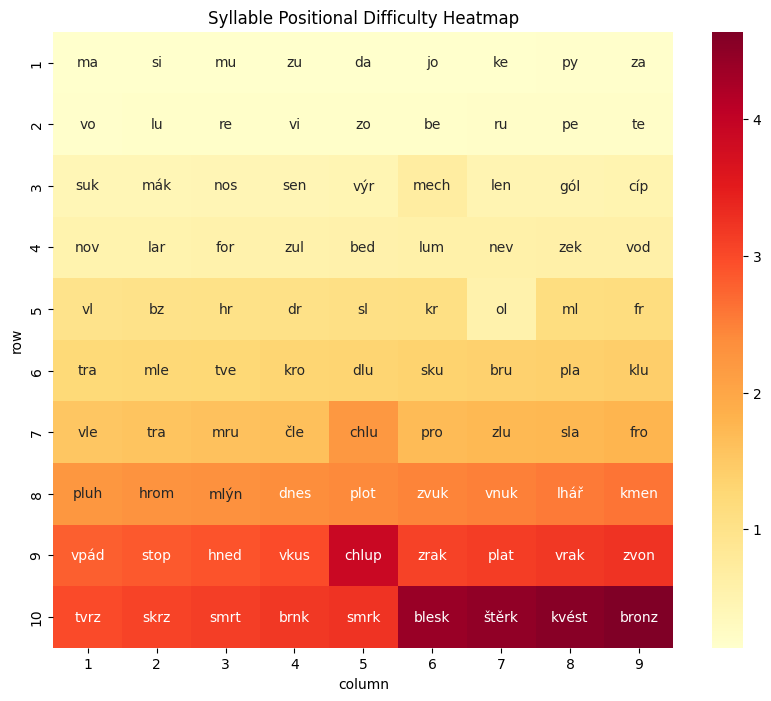

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
heatmap_data = syllable_analysis.pivot_table(
    values='positional_difficulty',
    index='row',
    columns='column'
)
sns.heatmap(heatmap_data, annot=syllables, fmt='', cmap='YlOrRd')
plt.title('Syllable Positional Difficulty Heatmap')
plt.savefig('syllable_complexity_heatmap.png')

In [ ]:
# Create dyslexia difficulty rating for each syllable
syllable_analysis['dyslexia_difficulty'] = (
    syllable_analysis['positional_difficulty'] * 0.3 +
    syllable_analysis['cluster_density'] * 0.25 +
    syllable_analysis['letter_confusability'] * 0.25 +
    syllable_analysis['orthographic_transparency'] * 0.2
)

In [ ]:
print("\nTop 10 Most Challenging Syllables for Dyslexia:")
top_difficult = syllable_analysis.sort_values('dyslexia_difficulty', ascending=False).head(10)
for _, row in top_difficult.iterrows():
    print(f"{row['syllable']} (Row {row['row']}, Col {row['column']}): {row['dyslexia_difficulty']:.2f}")


Top 10 Most Challenging Syllables for Dyslexia:
štěrk (Row 10, Col 7): 1.91
bronz (Row 10, Col 9): 1.79
kvést (Row 10, Col 8): 1.79
hned (Row 9, Col 3): 1.76
vpád (Row 9, Col 1): 1.75
blesk (Row 10, Col 6): 1.72
kmen (Row 8, Col 9): 1.67
vnuk (Row 8, Col 7): 1.64
chlup (Row 9, Col 5): 1.63
mlýn (Row 8, Col 3): 1.61


In [ ]:
# Export the final enhanced analysis
syllable_analysis.to_csv('syllable_dyslexia_analysis.csv', index=False)